In [1]:
pip install lxml

     |████████████████████████████████| 5.8MB 29.7MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install geopy

     |████████████████████████████████| 102kB 19.1MB/s ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geocoder

     |████████████████████████████████| 102kB 6.4MB/s ta 0:00:011
     |████████████████████████████████| 829kB 15.1MB/s eta 0:00:01
     |████████████████████████████████| 81kB 17.6MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [759]:
import pandas as pd
import json
import geopy
import geocoder
import folium
import requests
import json
import lxml


Importing the datasets of Toronto, Berlin and Paris. 

In [760]:
dftoronto= pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0] #scrape into table from wikipedia.
dfberlin= pd.read_csv('borough-neighborhood-berlin.csv', sep=";") #I already assembled this dataframe into a csv
dfparis = pd.read_csv('borough-neighborhood-paris.csv', sep=";") #I already assembled this dataframe into a csv. 

Import the dataset from New York as a JSON file and appending it to a new pandas dataframe. 

In [761]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset #downloading the new york dataset
print('Data downloaded!') 
with open('newyork_data.json') as json_data: 
    newyork_data = json.load(json_data) 
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
dfnewyork = pd.DataFrame(columns=column_names)
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    dfnewyork = dfnewyork.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


Data downloaded!


In [762]:
dfnewyork.to_csv('newyorkcoordinates.csv')

Let's take a quick look at the dataframes

In [763]:
dfberlin.head(), dfparis.head(), dftoronto.head(), dfnewyork.head()

(  postcode                     Borough   Neighbourhood
 0    0401   Charlottenburg-Wilmersdorf  Charlottenburg
 1    0402   Charlottenburg-Wilmersdorf     Wilmersdorf
 2    0403   Charlottenburg-Wilmersdorf   Schmargendorf
 3    0404   Charlottenburg-Wilmersdorf       Grunewald
 4    0405   Charlottenburg-Wilmersdorf         Westend,
    postcode          Borough              Neighbourhood
 0     75001  Arondissement 1  Saint-Germain-l'Auxerrois
 1     75001  Arondissement 1                 Les Halles
 2     75001  Arondissement 1               Palais-Royal
 3     75001  Arondissement 1              Place-Vendôme
 4     75002  Arondissement 2                    Gaillon,
   Postcode           Borough     Neighbourhood
 0      M1A      Not assigned      Not assigned
 1      M2A      Not assigned      Not assigned
 2      M3A        North York         Parkwoods
 3      M4A        North York  Victoria Village
 4      M5A  Downtown Toronto      Harbourfront,
   Borough Neighborhood   Latit

As we can see in the Dataframes above:
The Berlin dataframe has a postal code, a borough and a Neighbourhood. This is enough to find coordinates for the neigbourhoods. We will adress this in the next steps. 

The Paris dataframe has a postal code, a Borough and a Neighbourhood. This is also sufficient to find coordinates for the neighbourhoods. We will address this in the next steps. 

The Toronto dataframe has a postal code, a borough and a Neighbourhood. This is certainly enough to find the coordinates by the Neighbourhoods. We can see that some boroughs and neighbourhoods that are not assigned.This is something we should fix, which we will in the next steps. 

The new york dataframe seems to be the most complete. The only thing missing here are the postal codes, which we only need for finding coordinates. The new york dataframe already had coordinates, so we can leave this dataframe for now. 

The next steps.

1: Fixing the toronto dataframe, so the not assigned values are fixed. The following assumptions will apply in doing this: 

(in order)

If a Borough has the value "Not Assigned", the borough can be dropped. These are postal codes that do not have an assigned borough, so        they will be excluded.

If a Neighbourhood has the value "Not assigned", the name of the Borough will be used instead. The postal code is also linked to the          borough, so coordinates can be found. 

2: Finding coordinates for Berlin, Paris and Toronto. 

In [14]:
# Remodeling the dataframe, which excludes the Borough columns.  
dftoronto= dftoronto[dftoronto.Borough != 'Not assigned'] 
# != is unequal to, so only rows in the dataframe remain where borough has an assigned value
#Take a look at the new dataframe.
dftoronto.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [15]:
# We now have a dataframe where no borough exists where the value = "Not assigned". There are still Neighbourhoods that have the value
# "Not assigned", so we will replace the Neighbourhood values with the Borough values by iterating through the dataframe. We will
# use the length of the dataframe as range.
for i in range(len(dftoronto)):
    if dftoronto['Neighbourhood'].iloc[i] =='Not assigned':
        dftoronto['Neighbourhood'].iloc[i]= dftoronto['Borough'].iloc[i]
dftoronto.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


Now we have a dataframe that we can use to find coordinates for the neighbourhoods. We also will do this for the berlin and paris dataframe.
By writing a function that uses the geopy and geocoder library we can find the coordinates by looping through the dataframes. The geocoder service of arcgis will be used for this. 

In [16]:
#Writing the function that gets coordinates.
def get_geocoder(coordinatefinder):
     # initialize your variable to None
     lat_lng_coords = None
     # loop until you get the coordinates
     while(lat_lng_coords is None):
       g = geocoder.arcgis('{}, Toronto, Canada'.format(coordinatefinder)) 
       lat_lng_coords = g.latlng
     latitude = lat_lng_coords[0]
     longitude = lat_lng_coords[1]
     return latitude,longitude

#This loops through the dataframes and creates two new columns, named latitude and longitude by using the "Postcode" column of the 
#existing dataframe as input. 
dftoronto['Latitude'], dftoronto['Longitude'] = zip(*dftoronto['Postcode'].apply(get_geocoder)) 

In [17]:
dftoronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.752420,-79.329242
3,M4A,North York,Victoria Village,43.730600,-79.313265
4,M5A,Downtown Toronto,Harbourfront,43.650295,-79.359166
5,M6A,North York,Lawrence Heights,43.723270,-79.451286
6,M6A,North York,Lawrence Manor,43.723270,-79.451286


In [18]:
dftoronto.to_csv('torontocoordinates.csv')

After a few tries i found out that (by using postal code as search input) for berlin and paris the same coordinates are found over and over and they are the main coordinates of paris and berlin. 

To solve this i will add a column to both dataframes named "Address" to see if more values are generated. (the column exists of borough, neighbourhood, the city and the country. 

In [19]:
dfberlin["Address"] = dfberlin["Borough"] + str(", ") + dfberlin["Neighbourhood"] + str(", Berlin, Germany ")
dfparis["Address"] = dfparis["Borough"] + str(", ") + dfparis["Neighbourhood"] + str(", Paris, France ")
dfparis.head(),dfberlin.head()

(   postcode          Borough              Neighbourhood  \
 0     75001  Arondissement 1  Saint-Germain-l'Auxerrois   
 1     75001  Arondissement 1                 Les Halles   
 2     75001  Arondissement 1               Palais-Royal   
 3     75001  Arondissement 1              Place-Vendôme   
 4     75002  Arondissement 2                    Gaillon   
 
                                              Address  
 0  Arondissement 1, Saint-Germain-l'Auxerrois, Pa...  
 1        Arondissement 1, Les Halles, Paris, France   
 2      Arondissement 1, Palais-Royal, Paris, France   
 3     Arondissement 1, Place-Vendôme, Paris, France   
 4           Arondissement 2, Gaillon, Paris, France   ,
   postcode                     Borough   Neighbourhood  \
 0    0401   Charlottenburg-Wilmersdorf  Charlottenburg   
 1    0402   Charlottenburg-Wilmersdorf     Wilmersdorf   
 2    0403   Charlottenburg-Wilmersdorf   Schmargendorf   
 3    0404   Charlottenburg-Wilmersdorf       Grunewald   
 4    

In [20]:
# BERLIN
def get_geocoder(coordinatefinder):
     # initialize your variable to None
     lat_lng_coords = None
     # loop until you get the coordinates
     while(lat_lng_coords is None):
       g = geocoder.arcgis('{}, Berlin, Germany'.format(coordinatefinder))
       lat_lng_coords = g.latlng
     latitude = lat_lng_coords[0]
     longitude = lat_lng_coords[1]
     return latitude,longitude

#This loops through the dataframes and creates two new columns, named latitude and longitude by using the "Postcode" column of the 
#existing dataframe as input. 
dfberlin['Latitude'], dfberlin['Longitude'] = zip(*dfberlin['Address'].apply(get_geocoder)) 
dfberlin.head()

,postcode,Borough,Neighbourhood,Address,Latitude,Longitude
0,0401,Charlottenburg-Wilmersdorf,Charlottenburg,"Charlottenburg-Wilmersdorf, Charlottenburg, Be...",52.51915,13.30639
1,0402,Charlottenburg-Wilmersdorf,Wilmersdorf,"Charlottenburg-Wilmersdorf, Wilmersdorf, Berli...",52.48976,13.31519
2,0403,Charlottenburg-Wilmersdorf,Schmargendorf,"Charlottenburg-Wilmersdorf, Schmargendorf, Ber...",52.51915,13.30639
3,0404,Charlottenburg-Wilmersdorf,Grunewald,"Charlottenburg-Wilmersdorf, Grunewald, Berlin,...",52.49963,13.32297
4,0405,Charlottenburg-Wilmersdorf,Westend,"Charlottenburg-Wilmersdorf, Westend, Berlin, G...",52.49963,13.32297


In [21]:
dfberlin.to_csv('berlincoordinates.csv')

In [22]:
#PARIS
def get_geocoder(coordinatefinder):
     # initialize your variable to None
     lat_lng_coords = None
     # loop until you get the coordinates
     while(lat_lng_coords is None):
       g = geocoder.arcgis('{}, Paris, France'.format(coordinatefinder))
       lat_lng_coords = g.latlng
     latitude = lat_lng_coords[0]
     longitude = lat_lng_coords[1]
     return latitude,longitude

dfparis['Latitude'], dfparis['Longitude'] = zip(*dfparis['Address'].apply(get_geocoder)) 
dfparis.head()


,postcode,Borough,Neighbourhood,Address,Latitude,Longitude
0,75001,Arondissement 1,Saint-Germain-l'Auxerrois,"Arondissement 1, Saint-Germain-l'Auxerrois, Pa...",48.858087,2.345475
1,75001,Arondissement 1,Les Halles,"Arondissement 1, Les Halles, Paris, France",48.859107,2.347301
2,75001,Arondissement 1,Palais-Royal,"Arondissement 1, Palais-Royal, Paris, France",48.855803,2.346262
3,75001,Arondissement 1,Place-Vendôme,"Arondissement 1, Place-Vendôme, Paris, France",48.866750,2.328650
4,75002,Arondissement 2,Gaillon,"Arondissement 2, Gaillon, Paris, France",48.867708,2.333742


In [23]:
dfparis.to_csv('pariscoordinates.csv')

,Unnamed: 0,postcode,Borough,Neighbourhood,Address
0,0,75001,Arondissement 1,Saint-Germain-l'Auxerrois,"Arondissement 1, Saint-Germain-l'Auxerrois, Pa..."
1,1,75001,Arondissement 1,Les Halles,"Arondissement 1, Les Halles, Paris, France"
2,2,75001,Arondissement 1,Palais-Royal,"Arondissement 1, Palais-Royal, Paris, France"
3,3,75001,Arondissement 1,Place-Vendôme,"Arondissement 1, Place-Vendôme, Paris, France"
4,4,75002,Arondissement 2,Gaillon,"Arondissement 2, Gaillon, Paris, France"


Now all dataframes have coordinates. We can plot the boroughs and neighborhoods on a map now. Again we will use the geopy geocoder with the Nominatim geocoder. We will define the variables with the city names. 

In [5]:
from geopy.geocoders import Nominatim
address = 'Toronto, Canada'
address1 = 'Paris, France'
address2 = 'Berlin, Germany'
address3 = 'New York City, United states of America'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
location1 = geolocator.geocode(address1)
location2 = geolocator.geocode(address2)
location3 = geolocator.geocode(address3)
latitude = location.latitude
longitude = location.longitude
latitude1 = location1.latitude
longitude1 = location1.longitude
latitude2 = location2.latitude
longitude2 = location2.longitude
latitude3 = location3.latitude
longitude3 = location3.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))
print('The geograpical coordinates of Paris are {}, {}.'.format(latitude1, longitude1))
print('The geograpical coordinates of Berlin are {}, {}.'.format(latitude2, longitude2))
print('The geograpical coordinates of New York City are {}, {}.'.format(latitude3, longitude3))

The geograpical coordinates of Toronto are 43.653963, -79.387207.
The geograpical coordinates of Paris are 48.8566969, 2.3514616.
The geograpical coordinates of Berlin are 52.5170365, 13.3888599.
The geograpical coordinates of New York City are 40.7127281, -74.0060152.


In [25]:
# create maps of Toronto, Paris, Berlin and New York using latitude and longitude values
torontomap = folium.Map(location=[latitude, longitude], zoom_start=10)
parismap = folium.Map(location=[latitude1, longitude1], zoom_start=10)
berlinmap = folium.Map(location=[latitude2, longitude2], zoom_start=10)
newyorkmap = folium.Map(location=[latitude3, longitude3], zoom_start=10)
# add markers to map
for latitude, longitude, borough, neighbourhood in zip(dftoronto['Latitude'], 
                                                       dftoronto['Longitude'], 
                                                       dftoronto['Borough'], 
                                                       dftoronto['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(torontomap)
    
for latitude, longitude, borough, neighbourhood in zip(dfparis['Latitude'], 
                                                       dfparis['Longitude'], 
                                                       dfparis['Borough'], 
                                                       dfparis['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=3,
        popup=label,
        color='Yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(parismap)

for latitude, longitude, borough, neighbourhood in zip(dfberlin['Latitude'], 
                                                       dfberlin['Longitude'], 
                                                       dfberlin['Borough'], 
                                                       dfberlin['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(berlinmap)
    
for latitude, longitude, borough, neighborhood in zip(dfnewyork['Latitude'], 
                                                       dfnewyork['Longitude'], 
                                                       dfnewyork['Borough'], 
                                                       dfnewyork['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(newyorkmap)
    


In [26]:
#map toronto
torontomap 

In [27]:
#map paris
parismap

In [28]:
#map berlin
berlinmap

In [29]:
#map new york
newyorkmap

Now we have the maps of all the neighbourhoods in the different cities. Now we will connect to the foursquare API to see what differentiates the neighbourhoods from each other.

In [6]:
#setting up the Foursquare variables
CLIENT_ID = 'DS5ZIBWFIDHV4TFIZLDHPGMZGK4TZ5DYDM5SUGXUM33IC1ZH' # your Foursquare ID
CLIENT_SECRET = 'VTPKT11F5FGPBDFSGBLIRDCYLCC1FHLZAGOFC0N0YNYWFPPL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DS5ZIBWFIDHV4TFIZLDHPGMZGK4TZ5DYDM5SUGXUM33IC1ZH
CLIENT_SECRET:VTPKT11F5FGPBDFSGBLIRDCYLCC1FHLZAGOFC0N0YNYWFPPL


In [7]:
dftoronto.head()

NameError: name 'dftoronto' is not defined

In [34]:
dftoronto['Neighbourhood'].iloc[0]

'Parkwoods'

In [35]:
neighbourhood_latitude = dftoronto['Latitude'].iloc[0] # neighborhood latitude value
neighbourhood_longitude = dftoronto['Longitude'].iloc[0] # neighborhood longitude value

neighbourhood_name = dftoronto['Neighbourhood'].iloc[0] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Parkwoods are 43.75242000000003, -79.32924245299995.


In [36]:
#setting a limit of a 50 venues and a radius of 1 kilometer.
LIMIT = 50
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=DS5ZIBWFIDHV4TFIZLDHPGMZGK4TZ5DYDM5SUGXUM33IC1ZH&client_secret=VTPKT11F5FGPBDFSGBLIRDCYLCC1FHLZAGOFC0N0YNYWFPPL&v=20180605&ll=43.75242000000003,-79.32924245299995&radius=500&limit=50'

In [37]:
#checking if it works and seeing the first results:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e2d7375e826ac001bf65cec'},
 'response': {'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.75692000450003,
    'lng': -79.32302427998279},
   'sw': {'lat': 43.74791999550003, 'lng': -79.33546062601711}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.751976046055574,
          'lng': -79.33214044722958}],
        'distance': 238,
        'cc': '

In [38]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [39]:
#creating a new dataframe of venues
from pandas.io.json import json_normalize
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114
2,Corrosion Service Company Limited,Construction & Landscaping,43.752432,-79.334661
3,TTC stop - 44 Valley Woods,Bus Stop,43.755402,-79.333741


In [40]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


In [41]:
#creating a function that finds nearby venues and loops ahead.
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h2>Lets repeat this for all dataframes (berlin, paris, newyork, toronto)</h2>

In [44]:
toronto_venues = getNearbyVenues(names=dftoronto['Neighbourhood'],
                                   latitudes=dftoronto['Latitude'],
                                   longitudes=dftoronto['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront
Lawrence Heights
Lawrence Manor
Queen's Park
Queen's Park
Rouge
Malvern
Don Mills North
Woodbine Gardens
Parkview Hill
Ryerson
Garden District
Glencairn
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Downsview North
Wilson Heights
Thorncliffe Park
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
East Birchmount Park
Ionview
Kennedy Park
Bayview Village
CFB Toronto
Downsview East
The Danforth West
Riverdale
Design Exchange
Toronto 

In [46]:
print(toronto_venues.shape)
toronto_venues.head()
toronto_venues.to_csv('torontovenues.csv')

(3588, 7)


In [47]:
paris_venues = getNearbyVenues(names=dfparis['Neighbourhood'],
                                   latitudes=dfparis['Latitude'],
                                   longitudes=dfparis['Longitude']
                                  )

Saint-Germain-l'Auxerrois
Les Halles
Palais-Royal
Place-Vendôme
Gaillon
Vivienne
Mail
Bonne-Nouvelle
Arts-et-Métiers
Enfants-Rouges
Archives
Quartier Sainte-Avoye
Quartier Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Les Invalides
École-Militaire
Gros-Caillou
Champs-Élysées
Faubourg-du-Roule
La Madeleine
Europe
Saint-Georges
Chaussée-d'Antin
Faubourg-Montmartre
Rochechouart
Saint-Vincent-de-Paul
Porte-Saint-Denis
Porte-Saint-Martin
Hôpital-Saint-Louis
Folie-Méricourt
Saint-Ambroise
La Roquette
Sainte-Marguerite
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpêtrière
La Gare
Maison-Blanche
Croulebarbe
Montparnasse
Parc Montsouris
Petit-Montrouge
Plaisance
Saint-Lambert
Necker
Grenelle
Javel
Auteuil
La Muette
Porte-Dauphine
Chaillot
Les Ternes
Plaine de Monceau
Batignolles
Épinettes
Grandes-Carrières
Clignancourt
Goutte-d'Or
La Chapelle
La Villette
Pont-de-Flandres

In [48]:
print(paris_venues.shape)
paris_venues.head()
paris_venues.to_csv('parisvenues.csv')

(3663, 7)


In [49]:
berlin_venues = getNearbyVenues(names=dfberlin['Neighbourhood'],
                                   latitudes=dfberlin['Latitude'],
                                   longitudes=dfberlin['Longitude']
                                  )

Charlottenburg
Wilmersdorf
Schmargendorf
Grunewald
Westend
Charlottenburg-Nord
Halensee
Friedrichshain
Kreuzberg
Friedrichsfelde
Karlshorst
Lichtenberg
Falkenberg
Malchow
Wartenberg
Neu-Hohenschönhausen
Alt-Hohenschönhausen
Fennpfuhl
Rummelsburg
Biesdorf
Hellersdorf
Kaulsdorf
Mahlsdorf
Marzahn
Mitte
Moabit
Hansaviertel
Tiergarten
Wedding
Gesundbrunnen
Neukölln
Britz
Buckow
Rudow
Gropiusstadt
Prenzlauer Berg
Weissensee
Blankenburg
Heinersdorf
Karow
Stadtrandsiedlung Malchow
Pankow
Blankenfelde
Buch
Französisch Buchholz
Niederschönhausen
Rosenthal
Wilhelm
Reinickendorf
Tegel
Konradshöhe
Heiligensee
Frohnau
Hermsdorf
Waidmannslust
Lübars
Wittenau
Märkisches Viertel
Borsigwalde
Spandau
Haselhorst
Siemensstadt
Staaken
Gatow
Kladow
Hakenfelde
Falkenhagener Feld
Wilhelmstadt
Steglitz
Lichterfelde
Lankwitz
Zehlendorf
Dahlem
Nikolassee
Wannsee
Schöneberg
Friedenau
Tempelhof
Mariendorf
Marienfelde
Lichtenrade
Alt-Treptow
Plänterwald
Baumschulenweg
Johannisthal
Niederschöneweide
Altglienicke
Adle

In [50]:
print(berlin_venues.shape)
berlin_venues.head()
berlin_venues.to_csv('berlinvenues.csv')

(1804, 7)


In [51]:
NYC_venues = getNearbyVenues(names=dfnewyork['Neighborhood'],
                                   latitudes=dfnewyork['Latitude'],
                                   longitudes=dfnewyork['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [ ]:
print('There are {} unique categories in Toronto.'.format(len(toronto_venues['Venue Category'].unique())))
print('There are {} unique categories in Paris.'.format(len(paris_venues['Venue Category'].unique())))
print('There are {} unique categories in Berlin.'.format(len(berlin_venues['Venue Category'].unique())))
print('There are {} unique categories in NYC.'.format(len(NYC_venues['Venue Category'].unique())))

Let's take a look at one of the venue dataframes

In [373]:
berlinvenues=pd.read_csv('berlinvenues.csv')
parisvenues=pd.read_csv('parisvenues.csv')
NYCvenues=pd.read_csv('NYCvenues.csv')
torontovenues=pd.read_csv('torontovenues.csv')
torontovenues.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Parkwoods,43.75242,-79.329242,Brookbanks Park,43.751976,-79.332140,Park
1,1,Parkwoods,43.75242,-79.329242,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,2,Parkwoods,43.75242,-79.329242,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,3,Parkwoods,43.75242,-79.329242,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
4,4,Victoria Village,43.73060,-79.313265,Wigmore Park,43.731023,-79.310771,Park


We will now use one-hot-encoding, so we can later use the values for the KMEANS-clustering algorithm

In [374]:


# one hot encoding
berlin_onehot = pd.get_dummies(berlinvenues[['Venue Category']], prefix="", prefix_sep="")
paris_onehot = pd.get_dummies(parisvenues[['Venue Category']], prefix="", prefix_sep="")
NYC_onehot = pd.get_dummies(NYCvenues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot = pd.get_dummies(torontovenues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
berlin_onehot['NeighborhoodName'] = berlinvenues['Neighborhood'] 
paris_onehot['NeighborhoodName'] = parisvenues['Neighborhood'] 
NYC_onehot['NeighborhoodName'] = NYCvenues['Neighborhood'] 
toronto_onehot['NeighborhoodName'] = torontovenues['Neighborhood'] 

#berlin
neigh = berlin_onehot['NeighborhoodName']
berlin_onehot.drop(labels=['NeighborhoodName'], axis=1,inplace = True)
berlin_onehot.insert(0, 'NeighborhoodName', neigh)
#paris
neigh = paris_onehot['NeighborhoodName']
paris_onehot.drop(labels=['NeighborhoodName'], axis=1,inplace = True)
paris_onehot.insert(0, 'NeighborhoodName', neigh)
#nyc
neigh = NYC_onehot['NeighborhoodName']
NYC_onehot.drop(labels=['NeighborhoodName'], axis=1,inplace = True)
NYC_onehot.insert(0, 'NeighborhoodName', neigh)
#toronto
neigh = toronto_onehot['NeighborhoodName']
toronto_onehot.drop(labels=['NeighborhoodName'], axis=1,inplace = True)
toronto_onehot.insert(0, 'NeighborhoodName', neigh)


Grouping the dataframes by neighborhood

In [377]:
berlin_grouped = berlin_onehot.groupby("NeighborhoodName").mean().reset_index()
paris_grouped = paris_onehot.groupby("NeighborhoodName").mean().reset_index()
toronto_grouped = toronto_onehot.groupby("NeighborhoodName").mean().reset_index()
NYC_grouped = NYC_onehot.groupby("NeighborhoodName").mean().reset_index()

Writing a function that finds the 5 most common venues per neighborhood

In [384]:
num_top_venues = 5

for hood in berlin_grouped['NeighborhoodName']:
    print("----"+hood+"----")
    temp = berlin_grouped[berlin_grouped['NeighborhoodName'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    
    
num_top_venues = 5

for hood in paris_grouped['NeighborhoodName']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['NeighborhoodName'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    
    
    num_top_venues = 5

for hood in toronto_grouped['NeighborhoodName']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['NeighborhoodName'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    
    num_top_venues = 5

for hood in NYC_grouped['NeighborhoodName']:
    print("----"+hood+"----")
    temp = NYC_grouped[NYC_grouped['NeighborhoodName'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adlershof----
                venue  freq
0         Supermarket  0.18
1  Italian Restaurant  0.09
2   Trattoria/Osteria  0.09
3           Drugstore  0.09
4    Greek Restaurant  0.09


----Alt-Hohenschönhausen----
               venue  freq
0          Drugstore   0.2
1        Supermarket   0.1
2   Asian Restaurant   0.1
3              Hotel   0.1
4  Indian Restaurant   0.1


----Alt-Treptow----
                venue  freq
0  Italian Restaurant  0.08
1                Park  0.08
2         Coffee Shop  0.08
3                Café  0.08
4              Bistro  0.04


----Altglienicke----
               venue  freq
0        Supermarket  0.33
1  German Restaurant  0.17
2  Indian Restaurant  0.17
3     Discount Store  0.17
4      Bowling Alley  0.17


----Baumschulenweg----
        venue  freq
0      Bakery  0.14
1    Bus Stop  0.14
2   Drugstore  0.09
3  Smoke Shop  0.09
4        Café  0.09


----Biesdorf----
                 venue  freq
0          Supermarket  0.14
1  Outdoor Event Space  

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [389]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NeighborhoodName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
berlin_venues_sorted = pd.DataFrame(columns=columns)
berlin_venues_sorted['NeighborhoodName'] = berlin_grouped['NeighborhoodName']
paris_venues_sorted = pd.DataFrame(columns=columns)
paris_venues_sorted['NeighborhoodName'] = paris_grouped['NeighborhoodName']
NYC_venues_sorted = pd.DataFrame(columns=columns)
NYC_venues_sorted['NeighborhoodName'] = NYC_grouped['NeighborhoodName']
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['NeighborhoodName'] = toronto_grouped['NeighborhoodName']x

for ind in np.arange(berlin_grouped.shape[0]):
    berlin_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

for ind in np.arange(paris_grouped.shape[0]):
    paris_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)
    
for ind in np.arange(NYC_grouped.shape[0]):
    NYC_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NYC_grouped.iloc[ind, :], num_top_venues)
    
for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)


berlin_venues_sorted.columns,paris_venues_sorted.columns,NYC_venues_sorted.columns,toronto_venues_sorted.columns

(Index(['NeighborhoodName', '1st Most Common Venue', '2nd Most Common Venue',
        '3rd Most Common Venue', '4th Most Common Venue',
        '5th Most Common Venue', '6th Most Common Venue',
        '7th Most Common Venue', '8th Most Common Venue',
        '9th Most Common Venue', '10th Most Common Venue'],
       dtype='object'),
 Index(['NeighborhoodName', '1st Most Common Venue', '2nd Most Common Venue',
        '3rd Most Common Venue', '4th Most Common Venue',
        '5th Most Common Venue', '6th Most Common Venue',
        '7th Most Common Venue', '8th Most Common Venue',
        '9th Most Common Venue', '10th Most Common Venue'],
       dtype='object'),
 Index(['NeighborhoodName', '1st Most Common Venue', '2nd Most Common Venue',
        '3rd Most Common Venue', '4th Most Common Venue',
        '5th Most Common Venue', '6th Most Common Venue',
        '7th Most Common Venue', '8th Most Common Venue',
        '9th Most Common Venue', '10th Most Common Venue'],
       dtype='ob

In [396]:
berlin_grouped1=berlin_grouped.drop(["NeighborhoodName", "Neighborhood"], axis=1)
paris_grouped1=paris_grouped.drop(["NeighborhoodName"], axis=1)
NYC_grouped1=NYC_grouped.drop(["NeighborhoodName", "Neighborhood"], axis=1)
toronto_grouped1=toronto_grouped.drop(["NeighborhoodName", "Neighborhood"], axis=1)

                                    

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [397]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=[0, 1])
databerlin = scaler.fit_transform(berlin_grouped1)
dataparis = scaler.fit_transform(paris_grouped1)
dataNY = scaler.fit_transform(NYC_grouped1)
datatoronto = scaler.fit_transform(toronto_grouped1)


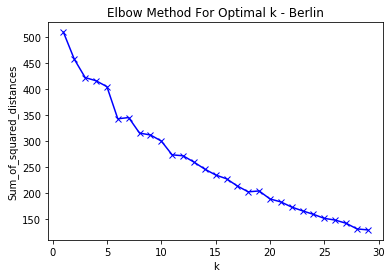

In [407]:

Sum_of_squared_distances = []
K = range(1, 30)
for kclusters in K:
    km = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(databerlin)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - Berlin')
plt.show()


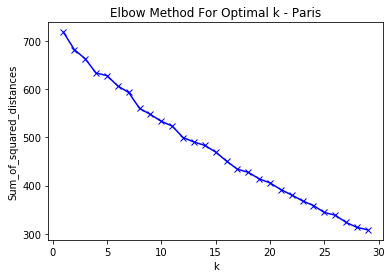

In [403]:

Sum_of_squared_distances = []
K = range(1, 30)
for kclusters in K:
    km = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(dataparis)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - Paris')
plt.show()


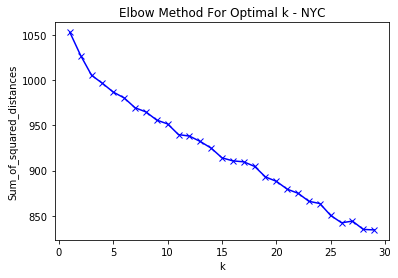

In [405]:

Sum_of_squared_distances = []
K = range(1, 30)
for kclusters in K:
    km = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(dataNY)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - NYC')
plt.show()


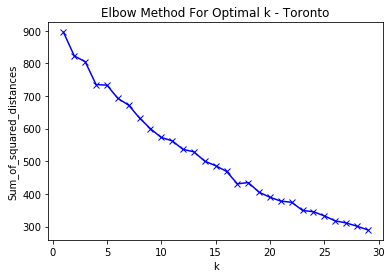

In [406]:

Sum_of_squared_distances = []
K = range(1, 30)
for kclusters in K:
    km = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(datatoronto)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - Toronto')
plt.show()


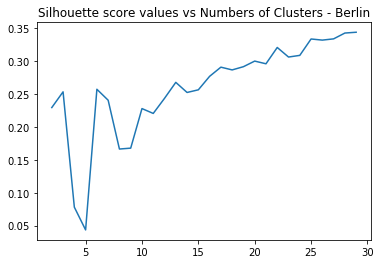

Optimal number of components is:
29


In [408]:

import numpy as numpy
import sklearn
import matplotlib.pyplot as plt
 
obs = databerlin.copy() 
# obs = numpy.concatenate( (numpy.random.randn(100, 2) , 20 + numpy.random.randn(300, 2) , -15+numpy.random.randn(200, 2)))
silhouette_score_values=list()
 
NumberOfClusters=range(2,30)
 
for i in NumberOfClusters:
    
    classifier=KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=10)
    classifier.fit(obs)
    labels= classifier.predict(obs)
#     print("Number Of Clusters:")
#     print(i)
#     print("Silhouette score value")
#     print(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', random_state=0))
 
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters - Berlin")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of components is:")
print(Optimal_NumberOf_Components)

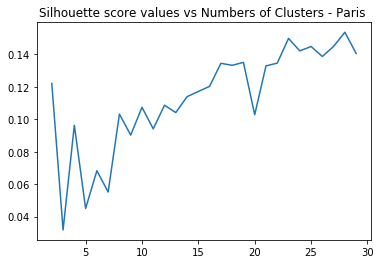

Optimal number of components is:
28


In [409]:
obs = dataparis.copy() 
# obs = numpy.concatenate( (numpy.random.randn(100, 2) , 20 + numpy.random.randn(300, 2) , -15+numpy.random.randn(200, 2)))
silhouette_score_values=list()
 
NumberOfClusters=range(2,30)
 
for i in NumberOfClusters:
    
    classifier=KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=10)
    classifier.fit(obs)
    labels= classifier.predict(obs)
#     print("Number Of Clusters:")
#     print(i)
#     print("Silhouette score value")
#     print(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', random_state=0))
 
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters - Paris ")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of components is:")
print(Optimal_NumberOf_Components)

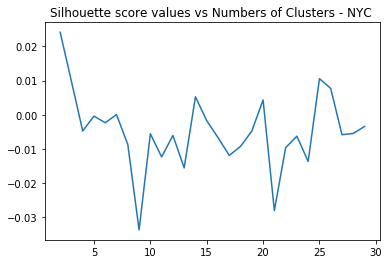

Optimal number of components is:
2


In [410]:
obs = dataNY.copy() 
# obs = numpy.concatenate( (numpy.random.randn(100, 2) , 20 + numpy.random.randn(300, 2) , -15+numpy.random.randn(200, 2)))
silhouette_score_values=list()
 
NumberOfClusters=range(2,30)
 
for i in NumberOfClusters:
    
    classifier=KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=10)
    classifier.fit(obs)
    labels= classifier.predict(obs)
#     print("Number Of Clusters:")
#     print(i)
#     print("Silhouette score value")
#     print(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', random_state=0))
 
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters - NYC ")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of components is:")
print(Optimal_NumberOf_Components)

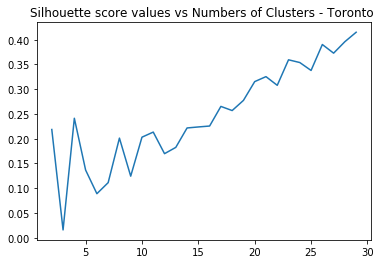

Optimal number of components is:
29


In [411]:
obs = datatoronto.copy() 
# obs = numpy.concatenate( (numpy.random.randn(100, 2) , 20 + numpy.random.randn(300, 2) , -15+numpy.random.randn(200, 2)))
silhouette_score_values=list()
 
NumberOfClusters=range(2,30)
 
for i in NumberOfClusters:
    
    classifier=KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=10)
    classifier.fit(obs)
    labels= classifier.predict(obs)
#     print("Number Of Clusters:")
#     print(i)
#     print("Silhouette score value")
#     print(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', random_state=0))
 
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters - Toronto ")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of components is:")
print(Optimal_NumberOf_Components)

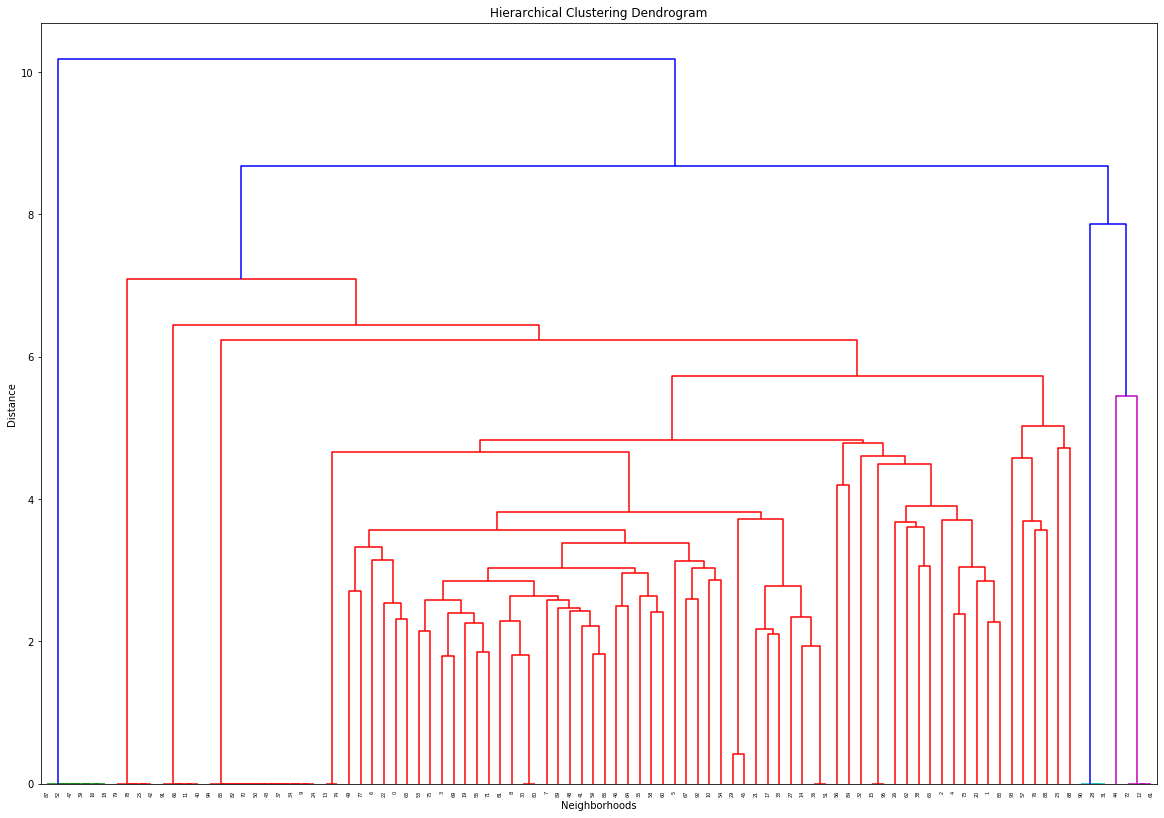

In [412]:

import scipy.cluster.hierarchy as shc

data = databerlin
plt.figure(figsize=(20, 14))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
#plt.axhline(y=1.8, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

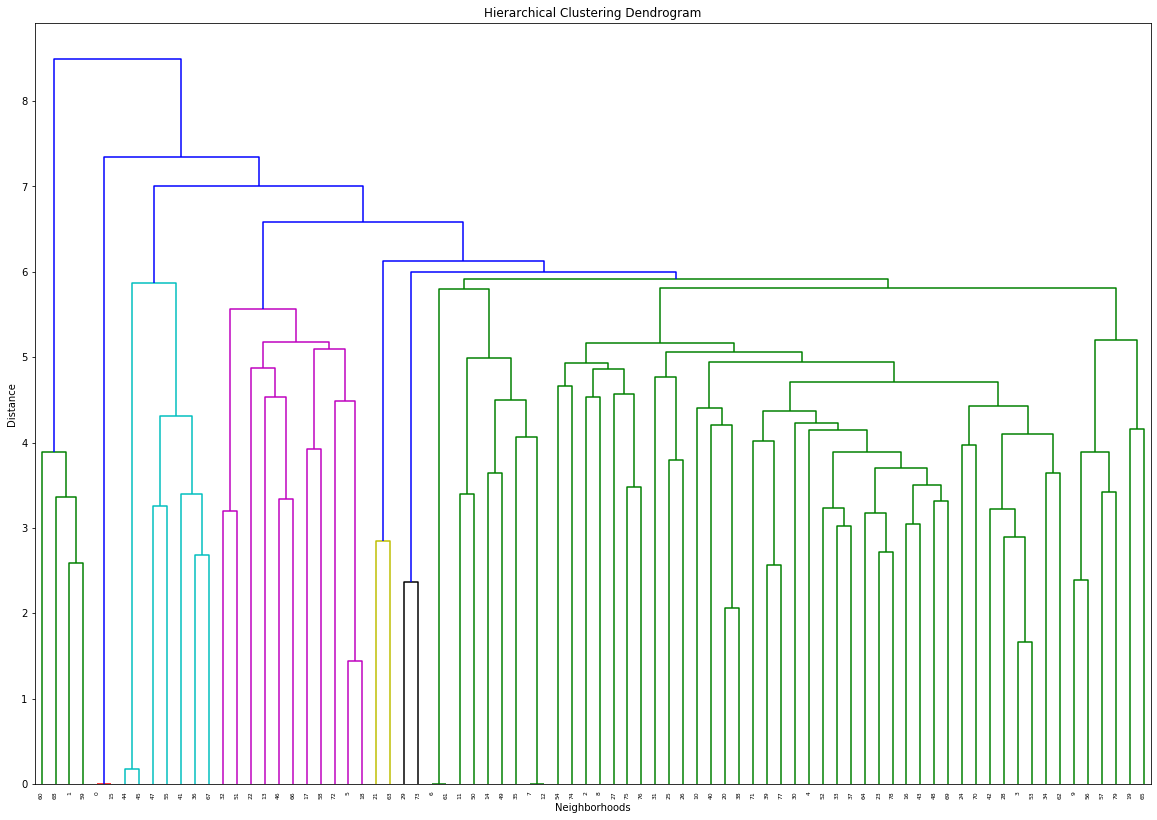

In [413]:
data = dataparis
plt.figure(figsize=(20, 14))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
#plt.axhline(y=1.8, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

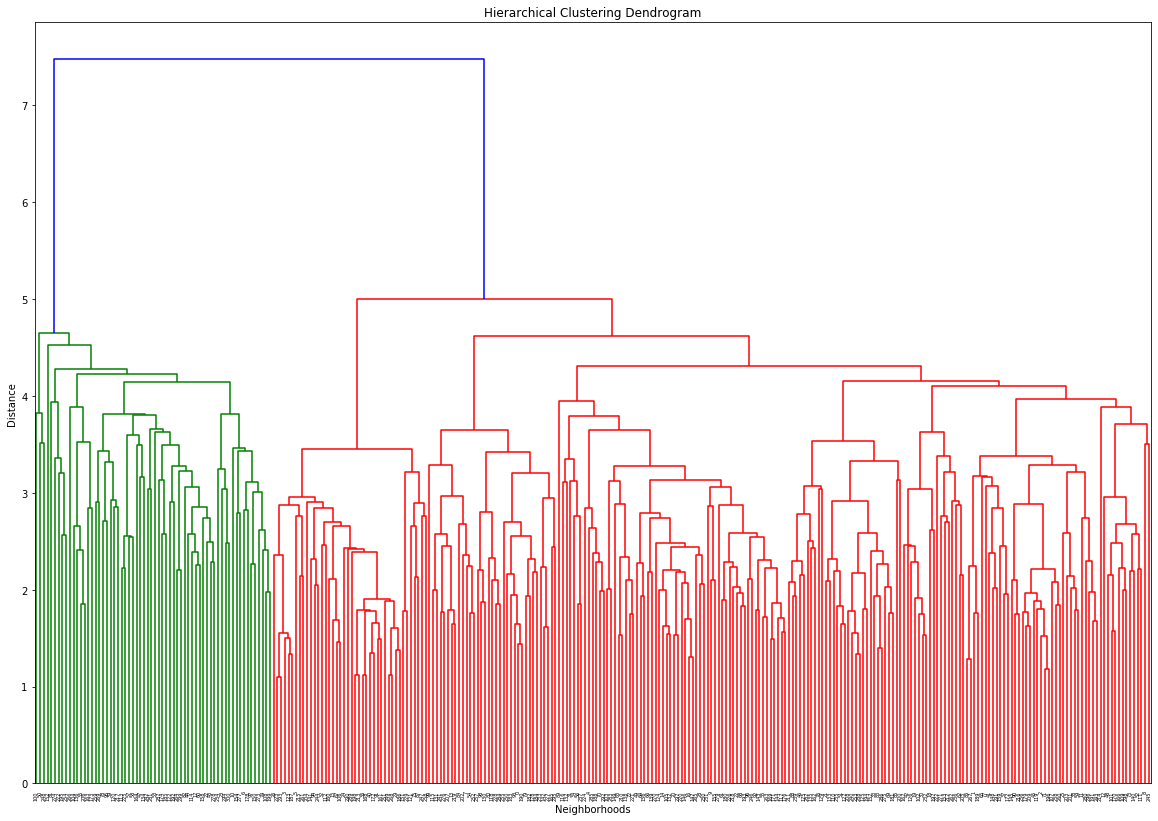

In [414]:
data = dataNY
plt.figure(figsize=(20, 14))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
#plt.axhline(y=1.8, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

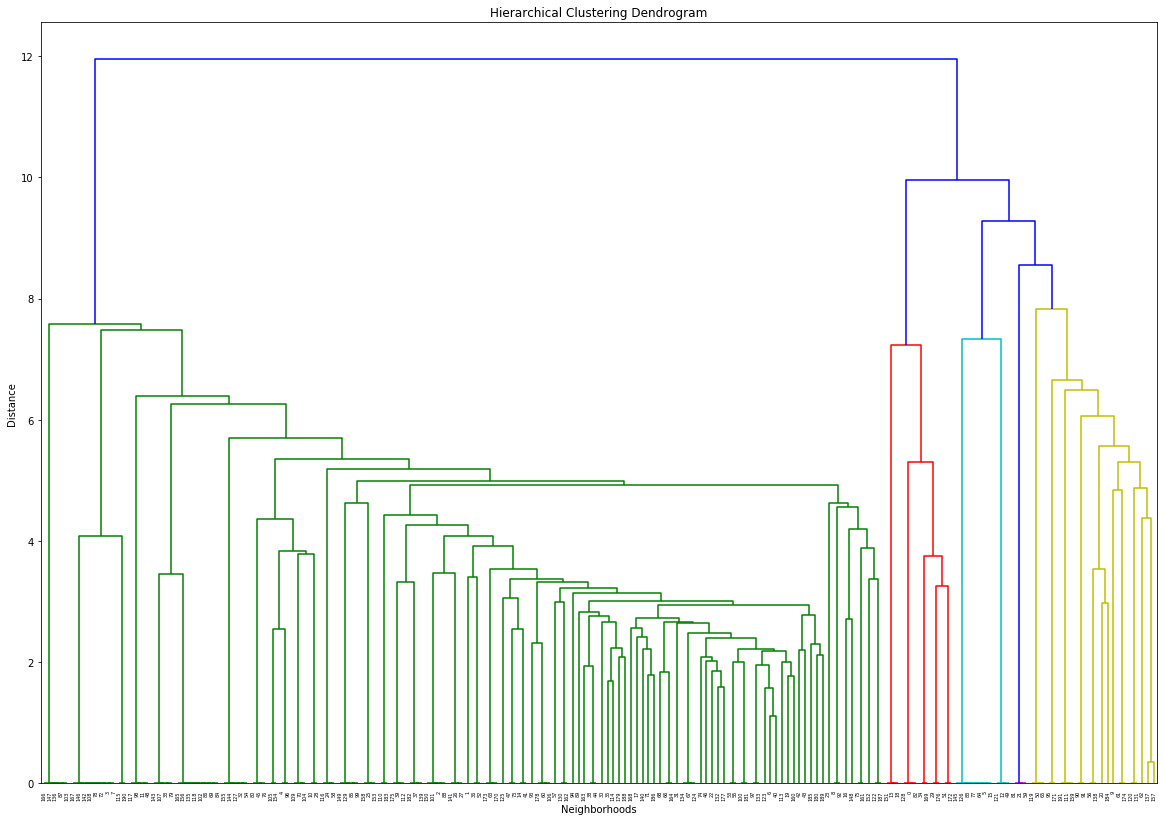

In [415]:
data = datatoronto
plt.figure(figsize=(20, 14))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
#plt.axhline(y=1.8, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

<h1> Berlin plotting</h1>

Let's plot the map of berlin, paris, newyork and toronto. . We will take the silhouette graphs as guidance for the number of clusters. 

In [765]:
df_grouped_clustering_berlin = databerlin.copy()
df_grouped_clustering_berlin

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [766]:

# set number of clusters
kclusters = 29


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=2, copy_x=True).fit(df_grouped_clustering_berlin)

# check cluster labels generated for each row in the dataframe
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

In [767]:
df_grouped_with_cluster = berlin_grouped.copy()
df_grouped_with_cluster.insert(0, 'Cluster_Labels', kmeans.labels_)
df_grouped_with_cluster.head()

,Cluster_Labels,NeighborhoodName,ATM,Accessories Store,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yemeni Restaurant,Yoga Studio
0,21,Adlershof,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,28,Alt-Hohenschönhausen,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.100000,...,0.0,0.0,0.000000,0.100000,0.0,0.0,0.0,0.0,0.0,0.0
2,18,Alt-Treptow,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.038462,...,0.0,0.0,0.038462,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,24,Altglienicke,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,24,Baumschulenweg,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.045455,...,0.0,0.0,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0


In [768]:
berlin_venues_sorted=berlin_venues_sorted.drop("Cluster_Labels",axis=1)

In [769]:
berlin_venues_sorted.insert(0,'Cluster_Labels', kmeans.labels_)

In [770]:
berlin_venues_sorted.head()

,Cluster_Labels,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,21,Adlershof,Supermarket,Steakhouse,Bank,Tanning Salon,Greek Restaurant,Drugstore,Tram Station,Trattoria/Osteria,Italian Restaurant,Plaza
1,28,Alt-Hohenschönhausen,Drugstore,Coffee Shop,Indian Restaurant,Supermarket,Hotel,Doner Restaurant,Asian Restaurant,Vietnamese Restaurant,Discount Store,French Restaurant
2,18,Alt-Treptow,Italian Restaurant,Park,Coffee Shop,Café,Bakery,Pizza Place,Farm,Rest Area,Restaurant,Organic Grocery
3,24,Altglienicke,Supermarket,Bowling Alley,Discount Store,German Restaurant,Indian Restaurant,Yoga Studio,Fountain,Food & Drink Shop,Food Court,Football Stadium
4,24,Baumschulenweg,Bakery,Bus Stop,Drugstore,Smoke Shop,Café,Supermarket,Italian Restaurant,Credit Union,Flower Shop,Chinese Restaurant


In [771]:
dfberlin  = pd.read_csv('berlincoordinates.csv')
dfberlin1 = dfberlin[["Neighbourhood", "Latitude","Longitude"]]
dfberlin2 = dfberlin1.rename(columns={'Neighbourhood':'NeighborhoodName'})
berlin_total = dfberlin2[['NeighborhoodName','Latitude','Longitude']]
berlin_total = berlin_total.merge(berlin_venues_sorted, on = 'NeighborhoodName', how = 'left')

In [772]:
# Visualize the clustered data
# Create map
map_clusters = folium.Map(location=[latitude2, longitude2], zoom_start=5)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_total['Latitude'], berlin_total['Longitude'], berlin_total['NeighborhoodName'], berlin_total['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [773]:
berlin_venues_sorted.loc[berlin_venues_sorted['Cluster_Labels'] == 0, berlin_venues_sorted.columns[[1] + list(range(2, berlin_venues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Borsigwalde,Pool,German Restaurant,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Football Stadium,Food Court
24,Frohnau,Pool,German Restaurant,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Football Stadium,Food Court
34,Heiligensee,Pool,German Restaurant,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Football Stadium,Food Court
37,Hermsdorf,Pool,German Restaurant,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Football Stadium,Food Court
43,Konradshöhe,Pool,German Restaurant,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Football Stadium,Food Court
50,Lübars,Pool,German Restaurant,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Football Stadium,Food Court
70,Reinickendorf,Pool,German Restaurant,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Football Stadium,Food Court
82,Tegel,Pool,German Restaurant,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Football Stadium,Food Court
85,Waidmannslust,Pool,German Restaurant,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Football Stadium,Food Court
94,Wittenau,Pool,German Restaurant,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Football Stadium,Food Court


<h1> Paris plotting</h1>

In [540]:
df_grouped_clustering_paris = dataparis.copy()
df_grouped_clustering_paris

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.43, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.43, 0.  , 0.  ]])

In [541]:

# set number of clusters
kclusters = 28


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=2, copy_x=True).fit(df_grouped_clustering_paris)

# check cluster labels generated for each row in the dataframe
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

In [542]:
df_grouped_with_cluster = paris_grouped.copy()
df_grouped_with_cluster.insert(0, 'Cluster_Labels', kmeans.labels_)
df_grouped_with_cluster.head()

,Cluster_Labels,NeighborhoodName,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,...,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,12,Amérique,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0
1,4,Archives,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.06,...,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0
2,0,Arsenal,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.034483,0.0,0.00,0.00,0.000000,0.0,0.0
3,1,Arts-et-Métiers,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.040000,0.0,0.04,0.02,0.000000,0.0,0.0
4,10,Auteuil,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.046512,0.0,0.0


In [ ]:
paris_venues_sorted=paris_venues_sorted.drop("Cluster_Labels",axis=1)

In [543]:
paris_venues_sorted.insert(0,'Cluster_Labels', kmeans.labels_)

In [544]:
dfparis = pd.read_csv('pariscoordinates.csv')
dfparis1 = dfparis[["Neighbourhood","Latitude","Longitude"]]
dfparis2 = dfparis1.rename(columns={'Neighbourhood':'NeighborhoodName'})
paris_total = dfparis2[['NeighborhoodName','Latitude','Longitude']]
paris_total = paris_total.merge(paris_venues_sorted, on = 'NeighborhoodName', how = 'left')

In [546]:
# Visualize the clustered data
# Create map
map_clusters = folium.Map(location=[latitude1, longitude1], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_total['Latitude'], paris_total['Longitude'], paris_total['NeighborhoodName'], paris_total['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [547]:
paris_venues_sorted.loc[paris_venues_sorted['Cluster_Labels'] == 0, paris_venues_sorted.columns[[1] + list(range(2, paris_venues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Arsenal,French Restaurant,Cocktail Bar,Plaza,Camera Store,Gastropub,Garden,Supermarket,Boat or Ferry,Museum,Canal Lock


<h1> NYC plotting</h1>

In [555]:
df_grouped_clustering_NYC = dataNY.copy()
df_grouped_clustering_NYC

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [556]:

# set number of clusters
kclusters = 25


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=2, copy_x=True).fit(df_grouped_clustering_NYC)

# check cluster labels generated for each row in the dataframe
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

In [563]:
df_grouped_with_cluster = NYC_grouped.copy()
df_grouped_with_cluster.insert(0, 'Cluster_Labels', kmeans.labels_)
df_grouped_with_cluster.head()

,Cluster_Labels,NeighborhoodName,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,3,Allerton,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,Annadale,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Arden Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Arlington,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Arrochar,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [564]:
NYC_venues_sorted=NYC_venues_sorted.drop("Cluster_Labels",axis=1)

In [565]:
NYC_venues_sorted.insert(0,'Cluster_Labels', kmeans.labels_)
NYC_venues_sorted.head()

,Cluster_Labels,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Allerton,Pizza Place,Chinese Restaurant,Cosmetics Shop,Supermarket,Deli / Bodega,Playground,Discount Store,Grocery Store,Gas Station,Breakfast Spot
1,3,Annadale,Pizza Place,Restaurant,Train Station,Dance Studio,American Restaurant,Deli / Bodega,Sports Bar,Pharmacy,Sushi Restaurant,Diner
2,3,Arden Heights,Deli / Bodega,Pharmacy,Bus Stop,Coffee Shop,Home Service,Pizza Place,Yoga Studio,Filipino Restaurant,Event Space,Exhibit
3,1,Arlington,Bus Stop,Intersection,American Restaurant,Deli / Bodega,Yoga Studio,Fish Market,Exhibit,Factory,Falafel Restaurant,Farm
4,4,Arrochar,Bus Stop,Italian Restaurant,Bagel Shop,Deli / Bodega,Liquor Store,Pizza Place,Hotel,Taco Place,Middle Eastern Restaurant,Athletics & Sports


In [584]:
dfnewyork = pd.read_csv('newyorkcoordinates.csv')
dfnewyork1 = dfnewyork[["Neighborhood","Latitude","Longitude"]] 
dfnewyork2 = dfnewyork1.rename(columns={'Neighborhood': 'NeighborhoodName'})
newyork_total = dfnewyork2[['NeighborhoodName','Latitude','Longitude']]
newyork_total = newyork_total.merge(NYC_venues_sorted, on = 'NeighborhoodName', how = 'left')
newyork_total.dropna(inplace = True)

newyork_total['Cluster_Labels'] =newyork_total['Cluster_Labels'].astype(int)


In [588]:
# create map
map_clusters = folium.Map(location=[latitude3, longitude3], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_total['Latitude'], newyork_total['Longitude'], newyork_total['NeighborhoodName'], newyork_total['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [604]:
NYC_venues_sorted.loc[NYC_venues_sorted['Cluster_Labels'] == 0, NYC_venues_sorted.columns[[1] + list(range(2, NYC_venues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
154,Little Italy,Café,Sandwich Place,Ice Cream Shop,Bakery,Wine Bar,Hotpot Restaurant,Clothing Store,Salon / Barbershop,Mediterranean Restaurant,Pizza Place


In [597]:
df_grouped_clustering_toronto = datatoronto.copy()
df_grouped_clustering_toronto

array([[0.        , 0.96      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.92307692, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [598]:
# set number of clusters
kclusters = 29


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=2, copy_x=True).fit(df_grouped_clustering_toronto)

# check cluster labels generated for each row in the dataframe
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

In [599]:
df_grouped_with_cluster = toronto_grouped.copy()
df_grouped_with_cluster.insert(0, 'Cluster_Labels', kmeans.labels_)
df_grouped_with_cluster.head()

,Cluster_Labels,NeighborhoodName,Airport,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,3,Adelaide,0.0,0.04,0.0,0.0,0.0,0.06,0.00,0.0,...,0.0,0.02,0.0,0.000000,0.0000,0.02,0.0,0.0,0.0,0.0
1,1,Agincourt,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,0.0,0.000000,0.0625,0.00,0.0,0.0,0.0,0.0
2,1,Agincourt North,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,0.0,0.000000,0.0000,0.00,0.0,0.0,0.0,0.0
3,6,Albion Gardens,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,0.0,0.066667,0.0000,0.00,0.0,0.0,0.0,0.0
4,22,Alderwood,0.0,0.00,0.0,0.0,0.0,0.00,0.25,0.0,...,0.0,0.00,0.0,0.000000,0.0000,0.00,0.0,0.0,0.0,0.0


In [600]:
toronto_venues_sorted=toronto_venues_sorted.drop("Cluster_Labels",axis=1)

In [601]:
toronto_venues_sorted.insert(0,'Cluster_Labels', kmeans.labels_)
toronto_venues_sorted.head()

,Cluster_Labels,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Adelaide,Coffee Shop,Café,Asian Restaurant,Steakhouse,American Restaurant,Gym,Seafood Restaurant,Hotel,Gastropub,Plaza
1,1,Agincourt,Chinese Restaurant,Shopping Mall,Sushi Restaurant,Park,Bubble Tea Shop,Grocery Store,Vietnamese Restaurant,Discount Store,Shanghai Restaurant,Hong Kong Restaurant
2,1,Agincourt North,Pharmacy,Sushi Restaurant,Yoga Studio,Dog Run,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
3,6,Albion Gardens,Grocery Store,Pizza Place,Beer Store,Fried Chicken Joint,Japanese Restaurant,Liquor Store,Fast Food Restaurant,Park,Pharmacy,Coffee Shop
4,22,Alderwood,Convenience Store,Pub,Athletics & Sports,Gym,Yoga Studio,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School


In [602]:
dftoronto = pd.read_csv('torontocoordinates.csv')
dftoronto1 = dftoronto[["Neighbourhood","Latitude","Longitude"]]
dftoronto2 = dftoronto1.rename(columns={'Neighbourhood': 'NeighborhoodName'})
toronto_total = dftoronto2[['NeighborhoodName','Latitude','Longitude']]
toronto_total = toronto_total.merge(toronto_venues_sorted, on = 'NeighborhoodName', how = 'left')
toronto_total.dropna(inplace = True)
toronto_total['Cluster_Labels'] =toronto_total['Cluster_Labels'].astype(int)

In [603]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_total['Latitude'], toronto_total['Longitude'], toronto_total['NeighborhoodName'], toronto_total['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [605]:
toronto_venues_sorted.loc[toronto_venues_sorted['Cluster_Labels'] == 0, toronto_venues_sorted.columns[[1] + list(range(2, toronto_venues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
87,Kingsway Park South West,Burrito Place,Burger Joint,Optical Shop,Sushi Restaurant,Middle Eastern Restaurant,Thai Restaurant,Bank,Coffee Shop,Miscellaneous Shop,Mattress Store
103,Mimico NW,Burrito Place,Burger Joint,Optical Shop,Sushi Restaurant,Middle Eastern Restaurant,Thai Restaurant,Bank,Coffee Shop,Miscellaneous Shop,Mattress Store
136,Royal York South West,Burrito Place,Burger Joint,Optical Shop,Sushi Restaurant,Middle Eastern Restaurant,Thai Restaurant,Bank,Coffee Shop,Miscellaneous Shop,Mattress Store
147,South of Bloor,Burrito Place,Burger Joint,Optical Shop,Sushi Restaurant,Middle Eastern Restaurant,Thai Restaurant,Bank,Coffee Shop,Miscellaneous Shop,Mattress Store
166,The Queensway West,Burrito Place,Burger Joint,Optical Shop,Sushi Restaurant,Middle Eastern Restaurant,Thai Restaurant,Bank,Coffee Shop,Miscellaneous Shop,Mattress Store


<h1> Total plotting</h1>

We are now going to repeat a  number of steps to create a clustering of all venues 

In [626]:
totalvenues.head()

,Unnamed: 0,NeighborhoodName,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Parkwoods,43.75242,-79.329242,Brookbanks Park,43.751976,-79.332140,Park
1,1,Parkwoods,43.75242,-79.329242,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,2,Parkwoods,43.75242,-79.329242,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,3,Parkwoods,43.75242,-79.329242,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
4,4,Victoria Village,43.73060,-79.313265,Wigmore Park,43.731023,-79.310771,Park


In [629]:

# one hot encoding
totalvenues_onehot = pd.get_dummies(totalvenues[['Venue Category']], prefix="", prefix_sep="")

totalvenues_onehot['NeighborhoodName'] = totalvenues['NeighborhoodName'] 

#all
neigh = totalvenues_onehot['NeighborhoodName']
totalvenues_onehot.drop(labels=['NeighborhoodName'], axis=1,inplace = True)
totalvenues_onehot.insert(0, 'NeighborhoodName', neigh)


In [631]:
total_grouped = totalvenues_onehot.groupby("NeighborhoodName").mean().reset_index()
num_top_venues = 5

for hood in total_grouped['NeighborhoodName']:
    print("----"+hood+"----")
    temp = total_grouped[total_grouped['NeighborhoodName'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    

----Adelaide----
              venue  freq
0              Café  0.10
1       Coffee Shop  0.10
2  Asian Restaurant  0.06
3        Steakhouse  0.06
4         Gastropub  0.04


----Adlershof----
           venue  freq
0    Supermarket  0.18
1     Steakhouse  0.09
2  Tanning Salon  0.09
3           Bank  0.09
4   Tram Station  0.09


----Agincourt----
                   venue  freq
0          Shopping Mall  0.12
1     Chinese Restaurant  0.12
2  Vietnamese Restaurant  0.06
3            Supermarket  0.06
4       Sushi Restaurant  0.06


----Agincourt North----
               venue  freq
0           Pharmacy   0.5
1   Sushi Restaurant   0.5
2  Paella Restaurant   0.0
3          Pet Store   0.0
4        Pet Service   0.0


----Albion Gardens----
                  venue  freq
0         Grocery Store  0.13
1              Pharmacy  0.07
2           Coffee Shop  0.07
3          Liquor Store  0.07
4  Caribbean Restaurant  0.07


----Alderwood----
                   venue  freq
0     Athletics & S

In [632]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [635]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NeighborhoodName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
totalvenues_sorted = pd.DataFrame(columns=columns)
totalvenues_sorted['NeighborhoodName'] = total_grouped['NeighborhoodName']


    
for ind in np.arange(total_grouped.shape[0]):
    totalvenues_sorted.iloc[ind, 1:] = return_most_common_venues(total_grouped.iloc[ind, :], num_top_venues)


totalvenues_sorted.head()

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Asian Restaurant,Steakhouse,Seafood Restaurant,Hotel,Gastropub,American Restaurant,Gym,Salad Place
1,Adlershof,Supermarket,Tanning Salon,Greek Restaurant,Steakhouse,Italian Restaurant,Bank,Plaza,Trattoria/Osteria,Drugstore,Tram Station
2,Agincourt,Chinese Restaurant,Shopping Mall,Grocery Store,Discount Store,Park,Pool,Vietnamese Restaurant,Badminton Court,Sushi Restaurant,Supermarket
3,Agincourt North,Pharmacy,Sushi Restaurant,Film Studio,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory
4,Albion Gardens,Grocery Store,Pharmacy,Video Store,Coffee Shop,Liquor Store,Park,Beer Store,Caribbean Restaurant,Pizza Place,Sandwich Place


In [636]:
total_grouped1=total_grouped.drop(["NeighborhoodName", "Neighborhood"], axis=1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=[0, 1])
datatotal = scaler.fit_transform(total_grouped1)



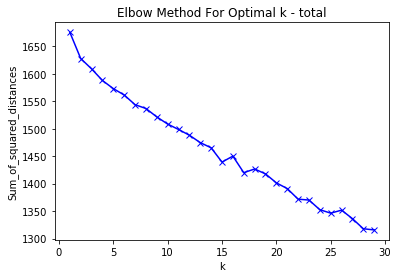

In [774]:

Sum_of_squared_distances = []
K = range(1, 30)
for kclusters in K:
    km = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(datatotal)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - total')
plt.show()



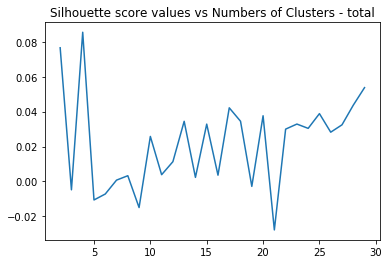

Optimal number of components is:
4


In [775]:

import numpy as numpy
import sklearn
import matplotlib.pyplot as plt
 
obs = datatotal.copy() 
# obs = numpy.concatenate( (numpy.random.randn(100, 2) , 20 + numpy.random.randn(300, 2) , -15+numpy.random.randn(200, 2)))
silhouette_score_values=list()
 
NumberOfClusters=range(2,30)
 
for i in NumberOfClusters:
    
    classifier=KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=10)
    classifier.fit(obs)
    labels= classifier.predict(obs)
#     print("Number Of Clusters:")
#     print(i)
#     print("Silhouette score value")
#     print(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', random_state=0))
 
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters - total")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of components is:")
print(Optimal_NumberOf_Components)

In [659]:
df_grouped_clustering_total = datatotal.copy()
df_grouped_clustering_total

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.32],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [876]:
# set number of clusters
kclusters = 16


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=2, copy_x=True).fit(df_grouped_clustering_total)

# check cluster labels generated for each row in the dataframe
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

In [877]:
df_grouped_with_cluster = total_grouped.copy()
df_grouped_with_cluster.insert(0, 'Cluster_Labels', kmeans.labels_)
df_grouped_with_cluster.head()

,Cluster_Labels,NeighborhoodName,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Alsatian Restaurant,American Restaurant,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
0,6,Adelaide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,...,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0
1,2,Adlershof,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,10,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,13,Agincourt North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,8,Albion Gardens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [878]:
totalvenues_sorted=totalvenues_sorted.drop("Cluster_Labels",axis=1)

In [879]:
totalvenues_sorted.insert(0,'Cluster_Labels', kmeans.labels_)
totalvenues_sorted.head()

,Cluster_Labels,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,6,Adelaide,Coffee Shop,Café,Asian Restaurant,Steakhouse,Seafood Restaurant,Hotel,Gastropub,American Restaurant,Gym,Salad Place
1,2,Adlershof,Supermarket,Tanning Salon,Greek Restaurant,Steakhouse,Italian Restaurant,Bank,Plaza,Trattoria/Osteria,Drugstore,Tram Station
2,10,Agincourt,Chinese Restaurant,Shopping Mall,Grocery Store,Discount Store,Park,Pool,Vietnamese Restaurant,Badminton Court,Sushi Restaurant,Supermarket
3,13,Agincourt North,Pharmacy,Sushi Restaurant,Film Studio,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory
4,8,Albion Gardens,Grocery Store,Pharmacy,Video Store,Coffee Shop,Liquor Store,Park,Beer Store,Caribbean Restaurant,Pizza Place,Sandwich Place


In [880]:
dfparis = pd.read_csv('pariscoordinates.csv')
dfparis1 = dfparis[["Neighbourhood","Latitude","Longitude"]]
dfparis2 = dfparis1.rename(columns={'Neighbourhood':'NeighborhoodName'})
paris_total = dfparis2[['NeighborhoodName','Latitude','Longitude']]
paris_total = paris_total.merge(neighborhoodvenues, on = 'NeighborhoodName', how = 'left')


dftoronto = pd.read_csv('torontocoordinates.csv')
dftoronto1 = dftoronto[["Neighbourhood","Latitude","Longitude"]]
dftoronto2 = dftoronto1.rename(columns={'Neighbourhood': 'NeighborhoodName'})
toronto_total = dftoronto2[['NeighborhoodName','Latitude','Longitude']]
toronto_total = toronto_total.merge(neighborhoodvenues, on = 'NeighborhoodName', how = 'left')


dfnewyork = pd.read_csv('newyorkcoordinates.csv')
dfnewyork1 = dfnewyork[["Neighborhood","Latitude","Longitude"]] 
dfnewyork2 = dfnewyork1.rename(columns={'Neighborhood': 'NeighborhoodName'})
newyork_total = dfnewyork2[['NeighborhoodName','Latitude','Longitude']]
newyork_total = newyork_total.merge(neighborhoodvenues, on = 'NeighborhoodName', how = 'left')


dfberlin  = pd.read_csv('berlincoordinates.csv')
dfberlin1 = dfberlin[["Neighbourhood", "Latitude","Longitude"]]
dfberlin2 = dfberlin1.rename(columns={'Neighbourhood':'NeighborhoodName'})
berlin_total = dfberlin2[['NeighborhoodName','Latitude','Longitude']]
berlin_total = berlin_total.merge(neighborhoodvenues, on = 'NeighborhoodName', how = 'left')

dftotal = pd.concat([berlin_total,newyork_total,toronto_total,paris_total])

dftotal

,NeighborhoodName,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg,52.519150,13.306390,0.0,Supermarket,Bakery,Italian Restaurant,Sushi Restaurant,Gym,Pet Café,Beer Garden,Middle Eastern Restaurant,Drugstore,Trattoria/Osteria
1,Wilmersdorf,52.489760,13.315190,11.0,Hotel,French Restaurant,Plaza,Café,Grocery Store,Doner Restaurant,Drugstore,Market,Bavarian Restaurant,Park
2,Schmargendorf,52.519150,13.306390,0.0,Supermarket,Bakery,Italian Restaurant,Sushi Restaurant,Gym,Pet Café,Beer Garden,Middle Eastern Restaurant,Drugstore,Trattoria/Osteria
3,Grunewald,52.499630,13.322970,0.0,Italian Restaurant,Café,Dessert Shop,Hotel,French Restaurant,Vietnamese Restaurant,Thai Restaurant,Gourmet Shop,Greek Restaurant,Seafood Restaurant
4,Westend,52.499630,13.322970,0.0,Italian Restaurant,Café,Dessert Shop,Hotel,French Restaurant,Vietnamese Restaurant,Thai Restaurant,Gourmet Shop,Greek Restaurant,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Combat,48.888230,2.391080,11.0,Bar,French Restaurant,Burger Joint,Japanese Restaurant,Sandwich Place,Theater,Grocery Store,Metro Station,Bike Rental / Bike Share,Gastropub
76,Belleville,48.873180,2.383470,11.0,Bar,French Restaurant,Café,Chinese Restaurant,Restaurant,Pizza Place,Dim Sum Restaurant,Coffee Shop,Cocktail Bar,Hostel
77,Saint-Fargeau,48.871450,2.401657,11.0,French Restaurant,Bakery,Supermarket,Market,Diner,Bar,Tapas Restaurant,Pizza Place,Chinese Restaurant,Café
78,Père-Lachaise,48.859784,2.361092,11.0,Clothing Store,French Restaurant,Art Gallery,Art Museum,Sandwich Place,Gourmet Shop,Bistro,Creperie,Burger Joint,Café


In [881]:
total = dftotal[['NeighborhoodName','Latitude','Longitude']]
total = total.merge(totalvenues_sorted, on = 'NeighborhoodName', how = 'left')
total.dropna(inplace = True)
total['Cluster_Labels'] =total['Cluster_Labels'].astype(int)
total

,NeighborhoodName,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg,52.519150,13.306390,2,Supermarket,Bakery,Italian Restaurant,Sushi Restaurant,Gym,Pet Café,Beer Garden,Middle Eastern Restaurant,Drugstore,Trattoria/Osteria
1,Wilmersdorf,52.489760,13.315190,0,Hotel,French Restaurant,Plaza,Café,Grocery Store,Doner Restaurant,Drugstore,Market,Bavarian Restaurant,Park
2,Schmargendorf,52.519150,13.306390,2,Supermarket,Bakery,Italian Restaurant,Sushi Restaurant,Gym,Pet Café,Beer Garden,Middle Eastern Restaurant,Drugstore,Trattoria/Osteria
3,Grunewald,52.499630,13.322970,0,Italian Restaurant,Café,Dessert Shop,Hotel,French Restaurant,Vietnamese Restaurant,Thai Restaurant,Gourmet Shop,Greek Restaurant,Seafood Restaurant
4,Westend,52.499630,13.322970,0,Italian Restaurant,Café,Dessert Shop,Hotel,French Restaurant,Vietnamese Restaurant,Thai Restaurant,Gourmet Shop,Greek Restaurant,Seafood Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,Combat,48.888230,2.391080,6,Bar,French Restaurant,Burger Joint,Japanese Restaurant,Sandwich Place,Theater,Grocery Store,Metro Station,Bike Rental / Bike Share,Gastropub
688,Belleville,48.873180,2.383470,0,Bar,French Restaurant,Café,Chinese Restaurant,Restaurant,Pizza Place,Dim Sum Restaurant,Coffee Shop,Cocktail Bar,Hostel
689,Saint-Fargeau,48.871450,2.401657,2,French Restaurant,Bakery,Supermarket,Market,Diner,Bar,Tapas Restaurant,Pizza Place,Chinese Restaurant,Café
690,Père-Lachaise,48.859784,2.361092,0,Clothing Store,French Restaurant,Art Gallery,Art Museum,Sandwich Place,Gourmet Shop,Bistro,Creperie,Burger Joint,Café


In [882]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(total['Latitude'], total['Longitude'], total['NeighborhoodName'], total['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [901]:

for ii in range(16):
    num = totalvenues_sorted[totalvenues_sorted['Cluster_Labels'] == ii].shape[0]
    print('Total number of neighborhoods in cluster {} is {}'.format(ii, num))

Total number of neighborhoods in cluster 0 is 79
Total number of neighborhoods in cluster 1 is 5
Total number of neighborhoods in cluster 2 is 254
Total number of neighborhoods in cluster 3 is 6
Total number of neighborhoods in cluster 4 is 5
Total number of neighborhoods in cluster 5 is 5
Total number of neighborhoods in cluster 6 is 84
Total number of neighborhoods in cluster 7 is 128
Total number of neighborhoods in cluster 8 is 14
Total number of neighborhoods in cluster 9 is 6
Total number of neighborhoods in cluster 10 is 19
Total number of neighborhoods in cluster 11 is 2
Total number of neighborhoods in cluster 12 is 15
Total number of neighborhoods in cluster 13 is 26
Total number of neighborhoods in cluster 14 is 6
Total number of neighborhoods in cluster 15 is 10


In [884]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 0, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Arsenal,French Restaurant,Cocktail Bar,Thai Restaurant,Canal Lock,Gastropub,Camera Store,Garden,Boat or Ferry,Vegetarian / Vegan Restaurant,Supermarket
17,Arts-et-Métiers,French Restaurant,Hotel,Seafood Restaurant,Vegetarian / Vegan Restaurant,Beer Store,Thai Restaurant,Bar,Japanese Restaurant,Vietnamese Restaurant,Coffee Shop
25,Batignolles,French Restaurant,Bar,Wine Bar,Hotel,Pub,Bakery,Bookstore,Gym / Fitness Center,Beer Bar,Noodle House
42,Belleville,Bar,French Restaurant,Café,Chinese Restaurant,Restaurant,Pizza Place,Dim Sum Restaurant,Coffee Shop,Cocktail Bar,Hostel
45,Bercy,Hotel,Italian Restaurant,French Restaurant,Japanese Restaurant,Bar,Museum,Wine Bar,Cosmetics Shop,Burger Joint,Multiplex
...,...,...,...,...,...,...,...,...,...,...,...
618,Vivienne,French Restaurant,Bistro,Clothing Store,Italian Restaurant,Wine Bar,Japanese Restaurant,General College & University,Historic Site,Garden,Lebanese Restaurant
632,Westend,Italian Restaurant,Café,Dessert Shop,Hotel,French Restaurant,Vietnamese Restaurant,Thai Restaurant,Gourmet Shop,Greek Restaurant,Seafood Restaurant
647,Wilmersdorf,Hotel,French Restaurant,Plaza,Café,Grocery Store,Doner Restaurant,Drugstore,Market,Bavarian Restaurant,Park
662,École-Militaire,Bar,French Restaurant,Japanese Restaurant,Bakery,Café,Park,Italian Restaurant,Music Venue,Theater,Bistro


In [885]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 1, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
226,Grant City,Pizza Place,Fast Food Restaurant,Mexican Restaurant,BBQ Joint,Tanning Salon,Asian Restaurant,Miscellaneous Shop,Grocery Store,Dessert Shop,Bar
275,Hunts Point,Spanish Restaurant,Waste Facility,Pizza Place,Home Service,Gourmet Shop,BBQ Joint,Café,Grocery Store,Farmers Market,Restaurant
355,Manor Heights,Liquor Store,Donut Shop,Deli / Bodega,Pharmacy,American Restaurant,BBQ Joint,Campground,Food,Chinese Restaurant,Food Court
625,Weeksville,Café,Discount Store,Plaza,Park,Pizza Place,Donut Shop,Liquor Store,Chinese Restaurant,History Museum,Lounge
649,Wingate,Fried Chicken Joint,Gym / Fitness Center,Flower Shop,Fast Food Restaurant,Field,Liquor Store,BBQ Joint,Discount Store,Fish & Chips Shop,Grocery Store


In [886]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 2, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Adlershof,Supermarket,Tanning Salon,Greek Restaurant,Steakhouse,Italian Restaurant,Bank,Plaza,Trattoria/Osteria,Drugstore,Tram Station
5,Alderwood,Pub,Convenience Store,Gym,Athletics & Sports,Yoga Studio,Falafel Restaurant,Fast Food Restaurant,Farmers Market,Farm,Exhibit
8,Alt-Treptow,Italian Restaurant,Park,Coffee Shop,Café,Dessert Shop,Farm,Bistro,Hookah Bar,Hostel,Bakery
9,Altglienicke,Supermarket,German Restaurant,Indian Restaurant,Bowling Alley,Discount Store,Event Service,Event Space,Ethiopian Restaurant,Exhibit,Film Studio
13,Arden Heights,Pharmacy,Pizza Place,Coffee Shop,Home Service,Deli / Bodega,Bus Stop,Yoga Studio,Falafel Restaurant,Farmers Market,Farm
...,...,...,...,...,...,...,...,...,...,...,...
651,Woburn,Korean Restaurant,Park,Indian Restaurant,Business Service,Coffee Shop,Falafel Restaurant,Fast Food Restaurant,Farmers Market,Farm,Yoga Studio
653,Woodbine Heights,Pharmacy,Bus Line,Café,Grocery Store,Doctor's Office,Arts & Crafts Store,Coffee Shop,Middle Eastern Restaurant,Gas Station,Pizza Place
655,Woodlawn,Pub,Deli / Bodega,Pizza Place,Playground,Food Truck,Italian Restaurant,Train Station,Donut Shop,Park,Supermarket
658,York Mills West,Bank,Park,Convenience Store,Speakeasy,Factory,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Exhibit


In [887]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 3, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
133,Deer Park,Light Rail Station,Coffee Shop,Supermarket,Liquor Store,Yoga Studio,Falafel Restaurant,Fast Food Restaurant,Farmers Market,Farm,Factory
195,Forest Hill SE,Light Rail Station,Coffee Shop,Supermarket,Liquor Store,Yoga Studio,Falafel Restaurant,Fast Food Restaurant,Farmers Market,Farm,Factory
318,Lankwitz,Liquor Store,Canal,Shoe Repair,Supermarket,Historic Site,Yoga Studio,Farm,Falafel Restaurant,Factory,Exhibit
481,Rathnelly,Light Rail Station,Coffee Shop,Supermarket,Liquor Store,Yoga Studio,Falafel Restaurant,Fast Food Restaurant,Farmers Market,Farm,Factory
546,South Hill,Light Rail Station,Coffee Shop,Supermarket,Liquor Store,Yoga Studio,Falafel Restaurant,Fast Food Restaurant,Farmers Market,Farm,Factory
572,Summerhill West,Light Rail Station,Coffee Shop,Supermarket,Liquor Store,Yoga Studio,Falafel Restaurant,Fast Food Restaurant,Farmers Market,Farm,Factory


In [888]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 4, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Alt-Hohenschönhausen,Drugstore,Asian Restaurant,Discount Store,Doner Restaurant,Indian Restaurant,Vietnamese Restaurant,Coffee Shop,Hotel,Supermarket,Factory
130,Dahlem,Café,Italian Restaurant,Drugstore,Doner Restaurant,Asian Restaurant,Gourmet Shop,Mobile Phone Shop,Organic Grocery,Fast Food Restaurant,Pizza Place
215,Gesundbrunnen,Doner Restaurant,Turkish Restaurant,Bakery,Hotel,Snack Place,Café,Soccer Field,Bar,Asian Restaurant,Pide Place
581,Tempelhof,Café,Park,Supermarket,Drugstore,Indian Restaurant,Doner Restaurant,Breakfast Spot,Bakery,Coffee Shop,Shopping Mall
661,Zehlendorf,Café,Italian Restaurant,Drugstore,Doner Restaurant,Asian Restaurant,Gourmet Shop,Mobile Phone Shop,Organic Grocery,Fast Food Restaurant,Pizza Place


In [889]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 6, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Asian Restaurant,Steakhouse,Seafood Restaurant,Hotel,Gastropub,American Restaurant,Gym,Salad Place
10,Amérique,Bar,French Restaurant,Burger Joint,Japanese Restaurant,Sandwich Place,Theater,Grocery Store,Metro Station,Bike Rental / Bike Share,Gastropub
19,Astoria,Bar,Greek Restaurant,Mediterranean Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Gourmet Shop,Pub,Hookah Bar,Gym,Indian Restaurant
28,Bay Ridge,Spa,Italian Restaurant,Greek Restaurant,Hookah Bar,Grocery Store,Pizza Place,American Restaurant,Bagel Shop,Ice Cream Shop,Chinese Restaurant
36,Bedford Stuyvesant,Bar,Coffee Shop,Pizza Place,Café,Fruit & Vegetable Store,Discount Store,Thrift / Vintage Store,Gourmet Shop,Cocktail Bar,Bagel Shop
...,...,...,...,...,...,...,...,...,...,...,...
617,Vinegar Hill,Food Truck,Café,Wine Shop,Art Gallery,Coffee Shop,Antique Shop,Scenic Lookout,Bakery,Men's Store,Ice Cream Shop
623,Washington Heights,Café,New American Restaurant,Deli / Bodega,Park,Coffee Shop,Tapas Restaurant,Mobile Phone Shop,Bakery,Wine Shop,Breakfast Spot
630,West Village,Italian Restaurant,Cocktail Bar,Cosmetics Shop,American Restaurant,Speakeasy,New American Restaurant,Bakery,Chinese Restaurant,Gastropub,Coffee Shop
642,Williamsburg,Coffee Shop,Bar,Bagel Shop,Yoga Studio,Breakfast Spot,Latin American Restaurant,Tapas Restaurant,Pet Store,Liquor Store,Lounge


In [890]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 7, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Allerton,Pizza Place,Chinese Restaurant,Supermarket,Deli / Bodega,Cosmetics Shop,Spanish Restaurant,Breakfast Spot,Spa,Fried Chicken Joint,Playground
11,Annadale,Pizza Place,Dance Studio,Diner,Sports Bar,Restaurant,Pharmacy,American Restaurant,Sushi Restaurant,Deli / Bodega,Train Station
15,Arrochar,Bus Stop,Italian Restaurant,Liquor Store,Bagel Shop,Deli / Bodega,Pizza Place,Food Truck,Polish Restaurant,Middle Eastern Restaurant,Outdoors & Recreation
23,Bath Beach,Chinese Restaurant,Pizza Place,Pharmacy,Sushi Restaurant,Italian Restaurant,Asian Restaurant,Bubble Tea Shop,Fast Food Restaurant,Donut Shop,Surf Spot
30,Baychester,Discount Store,Donut Shop,Pizza Place,Men's Store,Electronics Store,Mexican Restaurant,Baseball Field,Bank,Pet Store,Fast Food Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
628,West Farms,Bus Station,Bus Stop,Park,Metro Station,Diner,Hotel,Coffee Shop,Bank,Sandwich Place,Pizza Place
631,Westchester Square,Fast Food Restaurant,Pharmacy,Donut Shop,Sandwich Place,Pizza Place,Latin American Restaurant,Asian Restaurant,Gym,Metro Station,Mexican Restaurant
635,Weston,Pharmacy,Fried Chicken Joint,Diner,Convenience Store,Park,Pizza Place,Factory,Farmers Market,Farm,Falafel Restaurant
656,Woodrow,Pharmacy,Pizza Place,Coffee Shop,Home Service,Chinese Restaurant,Donut Shop,Liquor Store,Sushi Restaurant,Bagel Shop,Bakery


In [891]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 8, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Albion Gardens,Grocery Store,Pharmacy,Video Store,Coffee Shop,Liquor Store,Park,Beer Store,Caribbean Restaurant,Pizza Place,Sandwich Place
34,Beaumond Heights,Grocery Store,Pharmacy,Video Store,Coffee Shop,Liquor Store,Park,Beer Store,Caribbean Restaurant,Pizza Place,Sandwich Place
129,Cypress Hills,Fried Chicken Joint,Spanish Restaurant,Fast Food Restaurant,Ice Cream Shop,Donut Shop,Pizza Place,Latin American Restaurant,Discount Store,Supermarket,Gas Station
188,Flatlands,Pharmacy,Fried Chicken Joint,Fast Food Restaurant,Caribbean Restaurant,Video Store,Paper / Office Supplies Store,Park,Chinese Restaurant,Bar,Lounge
271,Humbergate,Grocery Store,Pharmacy,Video Store,Coffee Shop,Liquor Store,Park,Beer Store,Caribbean Restaurant,Pizza Place,Sandwich Place
285,Jamestown,Grocery Store,Pharmacy,Video Store,Coffee Shop,Liquor Store,Park,Beer Store,Caribbean Restaurant,Pizza Place,Sandwich Place
392,Mount Olive,Grocery Store,Pharmacy,Video Store,Coffee Shop,Liquor Store,Park,Beer Store,Caribbean Restaurant,Pizza Place,Sandwich Place
431,Old Town,Italian Restaurant,Gas Station,Pharmacy,Bakery,Liquor Store,Grocery Store,Donut Shop,Auto Garage,Pizza Place,Video Store
500,Rosebank,Italian Restaurant,Grocery Store,Pizza Place,Cosmetics Shop,Liquor Store,Bakery,Sandwich Place,Filipino Restaurant,Bar,Pharmacy
539,Silverstone,Grocery Store,Pharmacy,Video Store,Coffee Shop,Liquor Store,Park,Beer Store,Caribbean Restaurant,Pizza Place,Sandwich Place


In [892]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 9, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
87,Castleton Corners,Pizza Place,Bank,Japanese Restaurant,Ice Cream Shop,Bagel Shop,Mini Golf,Grocery Store,Tattoo Parlor,Sandwich Place,Burger Joint
217,Glencairn,Pizza Place,Japanese Restaurant,Sushi Restaurant,Mediterranean Restaurant,Grocery Store,Fast Food Restaurant,Latin American Restaurant,Ice Cream Shop,Asian Restaurant,Gas Station
335,Lindenwood,Japanese Restaurant,Fruit & Vegetable Store,Donut Shop,Pizza Place,Bank,Weight Loss Center,Bakery,Deli / Bodega,Hotel,Gym
418,Northwood Park,Japanese Restaurant,Fast Food Restaurant,Bar,Bank,Coffee Shop,Caribbean Restaurant,Miscellaneous Shop,Pizza Place,Massage Studio,Furniture / Home Store
456,Pomonok,Japanese Restaurant,Scenic Lookout,Supermarket,Bowling Alley,Halal Restaurant,Pizza Place,Playground,Bar,Daycare,English Restaurant
659,York University,Japanese Restaurant,Fast Food Restaurant,Bar,Bank,Coffee Shop,Caribbean Restaurant,Miscellaneous Shop,Pizza Place,Massage Studio,Furniture / Home Store


In [893]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 10, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Agincourt,Chinese Restaurant,Shopping Mall,Grocery Store,Discount Store,Park,Pool,Vietnamese Restaurant,Badminton Court,Sushi Restaurant,Supermarket
54,Bloordale Gardens,Shopping Mall,Carpet Store,College Rec Center,Grocery Store,Fish & Chips Shop,Pizza Place,Electronics Store,Event Space,Farmers Market,Event Service
107,Clarks Corners,Pizza Place,Convenience Store,Golf Course,Coffee Shop,Hobby Shop,Bus Stop,Chinese Restaurant,Pharmacy,Fried Chicken Joint,Shopping Mall
152,East Birchmount Park,Chinese Restaurant,Department Store,Discount Store,Convenience Store,Coffee Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
173,Eringate,Shopping Mall,Carpet Store,College Rec Center,Grocery Store,Fish & Chips Shop,Pizza Place,Electronics Store,Event Space,Farmers Market,Event Service
190,Floral Park,Indian Restaurant,Dosa Place,Hobby Shop,Salon / Barbershop,Grocery Store,Pizza Place,Basketball Court,Exhibit,Event Space,Farmers Market
218,Glendale,Food & Drink Shop,Brewery,Arts & Crafts Store,Pizza Place,Yoga Studio,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Factory
279,Ionview,Chinese Restaurant,Department Store,Discount Store,Convenience Store,Coffee Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
293,Kennedy Park,Chinese Restaurant,Department Store,Discount Store,Convenience Store,Coffee Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
303,Kingsview Village,Bus Line,Pizza Place,Arts & Crafts Store,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Yoga Studio,Film Studio


In [894]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 11, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,Birch Cliff,Skating Rink,Gym,General Entertainment,College Stadium,Park,Gym Pool,Farmers Market,Farm,Falafel Restaurant,Yoga Studio
111,Cliffside West,Skating Rink,Gym,General Entertainment,College Stadium,Park,Gym Pool,Farmers Market,Farm,Falafel Restaurant,Yoga Studio


In [895]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 12, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
59,Borsigwalde,German Restaurant,Pool,Yoga Studio,Filipino Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
208,Frohnau,German Restaurant,Pool,Yoga Studio,Filipino Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
238,Grünau,German Restaurant,Beer Garden,River,Farmers Market,Soccer Field,Shopping Mall,Supermarket,Drugstore,Event Space,Exhibit
251,Heiligensee,German Restaurant,Pool,Yoga Studio,Filipino Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
255,Hermsdorf,German Restaurant,Pool,Yoga Studio,Filipino Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
307,Konradshöhe,German Restaurant,Pool,Yoga Studio,Filipino Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
309,Köpenick,German Restaurant,Beer Garden,River,Drugstore,Soccer Field,Farmers Market,Café,Shopping Mall,Supermarket,Food
332,Lichterfelde,Indian Restaurant,Pub,Plaza,German Restaurant,Gas Station,Bus Stop,Vietnamese Restaurant,Auto Dealership,Indie Movie Theater,Trattoria/Osteria
343,Lübars,German Restaurant,Pool,Yoga Studio,Filipino Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
373,Mill Island,Pool,Yoga Studio,Filipino Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory


In [896]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 13, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Agincourt North,Pharmacy,Sushi Restaurant,Film Studio,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory
63,Britz,Fast Food Restaurant,Automotive Shop,Hardware Store,Harbor / Marina,Intersection,Hookah Bar,Pizza Place,Falafel Restaurant,Factory,Exhibit
134,Del Ray,Construction & Landscaping,Coffee Shop,Fast Food Restaurant,Yoga Studio,Filipino Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space
170,Emery,Coffee Shop,Nightclub,Park,Yoga Studio,Filipino Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
268,Humber Bay,Italian Restaurant,Fast Food Restaurant,Sushi Restaurant,Coffee Shop,Yoga Studio,Factory,Farmers Market,Farm,Falafel Restaurant,Event Space
272,Humberlea,Coffee Shop,Nightclub,Park,Yoga Studio,Filipino Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
292,Keelesdale,Construction & Landscaping,Coffee Shop,Fast Food Restaurant,Yoga Studio,Filipino Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space
300,King's Mill Park,Italian Restaurant,Fast Food Restaurant,Sushi Restaurant,Coffee Shop,Yoga Studio,Factory,Farmers Market,Farm,Falafel Restaurant,Event Space
304,Kingsway Park South East,Italian Restaurant,Fast Food Restaurant,Sushi Restaurant,Coffee Shop,Yoga Studio,Factory,Farmers Market,Farm,Falafel Restaurant,Event Space
310,L'Amoreaux East,Pharmacy,Sushi Restaurant,Film Studio,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory


In [897]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 14, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
177,Falkenberg,Italian Restaurant,Bakery,Supermarket,Coffee Shop,Burrito Place,Soccer Stadium,Recreation Center,Pub,Donut Shop,Drugstore
182,Fennpfuhl,Italian Restaurant,Bakery,Supermarket,Coffee Shop,Burrito Place,Soccer Stadium,Recreation Center,Pub,Donut Shop,Drugstore
289,Karlshorst,Italian Restaurant,Bakery,Supermarket,Coffee Shop,Burrito Place,Soccer Stadium,Recreation Center,Pub,Donut Shop,Drugstore
330,Lichtenberg,Italian Restaurant,Bakery,Supermarket,Coffee Shop,Burrito Place,Soccer Stadium,Recreation Center,Pub,Donut Shop,Drugstore
349,Malchow,Italian Restaurant,Bakery,Supermarket,Coffee Shop,Burrito Place,Soccer Stadium,Recreation Center,Pub,Donut Shop,Drugstore
622,Wartenberg,Italian Restaurant,Bakery,Supermarket,Coffee Shop,Burrito Place,Soccer Stadium,Recreation Center,Pub,Donut Shop,Drugstore


In [898]:
totalvenues_sorted.loc[totalvenues_sorted['Cluster_Labels'] == 15, totalvenues_sorted.columns[[1] + list(range(2, totalvenues_sorted.shape[1]))]]

,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Bay Terrace,Clothing Store,Donut Shop,Supermarket,Kids Store,American Restaurant,Cosmetics Shop,Lingerie Store,Mobile Phone Shop,Women's Store,Shoe Store
176,Fairview,Clothing Store,Fast Food Restaurant,Coffee Shop,Women's Store,Japanese Restaurant,Toy / Game Store,Juice Bar,Tea Room,Food Court,Thai Restaurant
254,Henry Farm,Clothing Store,Fast Food Restaurant,Coffee Shop,Women's Store,Japanese Restaurant,Toy / Game Store,Juice Bar,Tea Room,Food Court,Thai Restaurant
314,La Madeleine,Hotel,French Restaurant,Boutique,Dessert Shop,Gourmet Shop,Plaza,Cocktail Bar,Chocolate Shop,Sandwich Place,Men's Store
320,Lawrence Heights,Clothing Store,Men's Store,Cosmetics Shop,Toy / Game Store,Furniture / Home Store,American Restaurant,Food Court,Chocolate Shop,Shopping Mall,Greek Restaurant
321,Lawrence Manor,Clothing Store,Men's Store,Cosmetics Shop,Toy / Game Store,Furniture / Home Store,American Restaurant,Food Court,Chocolate Shop,Shopping Mall,Greek Restaurant
370,Midtown South,Korean Restaurant,Coffee Shop,Dessert Shop,Italian Restaurant,Fried Chicken Joint,Japanese Restaurant,Hotel,Lingerie Store,Golf Course,Market
433,Oriole,Clothing Store,Fast Food Restaurant,Coffee Shop,Women's Store,Japanese Restaurant,Toy / Game Store,Juice Bar,Tea Room,Food Court,Thai Restaurant
451,Place-Vendôme,French Restaurant,Hotel,Hotel Bar,Jewelry Store,Boutique,Chocolate Shop,Japanese Restaurant,Bookstore,Historic Site,Plaza
541,Soho,Clothing Store,Women's Store,Boutique,Shoe Store,Sporting Goods Shop,Art Gallery,Men's Store,Yoga Studio,Salon / Barbershop,Tea Room


Thank you for reading this notebook